# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Reading The Datasets

In [2]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.shape[0]

10

In [4]:
portfolio.shape[1]

6

In [5]:
print('portfolio: rows = {} ,columns = {}'.format((portfolio.shape[0]),(portfolio.shape[1])))

portfolio: rows = 10 ,columns = 6


In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [8]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [9]:
portfolio.reward.value_counts()

5     3
10    2
2     2
0     2
3     1
Name: reward, dtype: int64

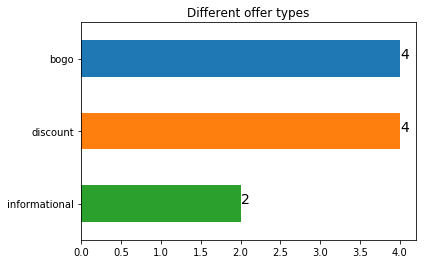

In [82]:
import matplotlib.pyplot as plt
plt.figure(figsize=[6,6])
fig, ax = plt.subplots()    
y_counts = portfolio['offer_type'].value_counts()
y_counts.plot(kind='barh').invert_yaxis()
       
for i, v in enumerate(y_counts):
    ax.text(v, i, str(v), fontsize=14)
    plt.title('Different offer types')

Discount and bogo are equally given and on maximum times

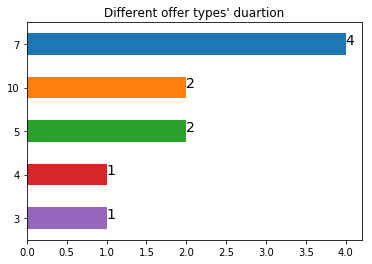

In [83]:
plt.figure(figsize=[6,6])
fig, ax = plt.subplots()    
y_counts = portfolio['duration'].value_counts()
y_counts.plot(kind='barh').invert_yaxis()
       
for i, v in enumerate(y_counts):
    ax.text(v, i, str(v), color='black', fontsize=14)
    plt.title('Different offer types\' duartion')

Here we can see that most of the offers are for the duration of 7 days

### Profile

In [13]:
profile.head(8)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [14]:
print('profile: rows = {} ,columns = {}'.format((profile.shape[0]),(profile.shape[1])))

profile: rows = 17000 ,columns = 5


In [15]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [16]:
profile.isnull().sum()
profile.shape

(17000, 5)

In [17]:
import seaborn as sns

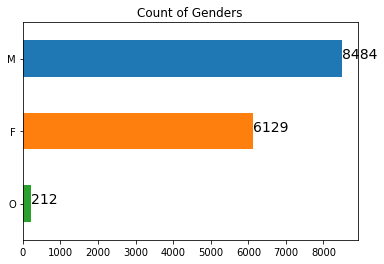

In [18]:
    plt.figure(figsize=[6,6])
    fig, ax = plt.subplots()    
    y_counts = profile['gender'].value_counts()
    y_counts.plot(kind='barh').invert_yaxis()
       
    for i, v in enumerate(y_counts):
        ax.text(v, i, str(v), color='black', fontsize=14)
        plt.title('Count of Genders')

([<matplotlib.patches.Wedge at 0x7f5bf1c38320>,
 [Text(-0.247629,1.07176,'Male'),
  Text(0.199246,-1.0818,'Female'),
  Text(1.09889,-0.0494014,'Other')])

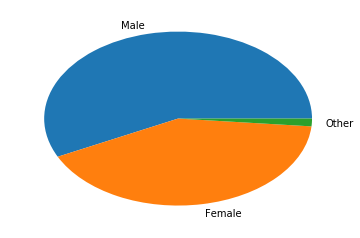

In [19]:
plt.pie(profile['gender'].value_counts() , labels = ['Male' , 'Female' , 'Other'])

Mostly male are interested in the offers and they are the major ones

### Transcript

In [20]:
transcript.head(9)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [21]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [22]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [23]:
print('transcript: rows = {} ,columns = {}'.format((profile.shape[0]),(profile.shape[1])))

transcript: rows = 17000 ,columns = 5


### Cleaning The Datasets

#### Portfolio

Renaming 'id' to 'offer_id'                                                                                            

In [24]:
portfolio.columns = ['channels', 'difficulty', 'duration', 'offer_id', 'offer_type', 'reward']

In [25]:
portfolio.columns

Index(['channels', 'difficulty', 'duration', 'offer_id', 'offer_type',
       'reward'],
      dtype='object')

In [26]:
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


# Profile

Renaming 'id' to 'customer_id' , filling the missing values of age and income with mean value , filling the missing values of gender with mode

In [27]:
profile.columns

Index(['age', 'became_member_on', 'gender', 'id', 'income'], dtype='object')

In [28]:
profile.columns = ['age', 'became_member_on', 'gender', 'customer_id', 'income']

In [29]:
profile.columns

Index(['age', 'became_member_on', 'gender', 'customer_id', 'income'], dtype='object')

In [30]:
profile['age'].fillna(profile['age'].mean()) #filling missing age with average age
profile['income'].fillna(profile['income'].mean()) #filling missing income with average income
profile['gender'].fillna(profile['gender'].mode()[0]) #filling missing gender with the most occuring gender
profile.head()

,age,became_member_on,gender,customer_id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [31]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
customer_id            0
income              2175
dtype: int64

So there is not any missing value remaining in the profile dataframe

# Transcript

Renaming 'person' to 'customer_id' , splitting the 'value' column based on its keys and
dropping the unnecessary columns

In [32]:
transcript.columns

Index(['event', 'person', 'time', 'value'], dtype='object')

In [33]:
transcript.columns = ['event', 'customer_id', 'time', 'value'] #changing the column name

In [34]:
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [35]:
transcript.value.astype('str').value_counts().to_dict() #converting the values in the column 'value' to dictionary

{"{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}": 14983,
 "{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}": 14924,
 "{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}": 14891,
 "{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}": 14835,
 "{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}": 14374,
 "{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}": 14305,
 "{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}": 11848,
 "{'offer id': '3f207df678b143eea3cee63160fa8bed'}": 11761,
 "{'offer id': '2906b810c7d4411798c6938adc9daaa5'}": 11750,
 "{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}": 10331,
 "{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}": 5317,
 "{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}": 5156,
 "{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}": 4354,
 "{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}": 4296,
 "{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}": 4017,
 "{'offer_id': 'ae264e3637204a6fb9bb56bc

In [36]:
transcript['offer_id'] = transcript.value.apply(lambda x: x.get('offer_id')) #splitting the 'value' into separate columns.here is 'offer_id'
transcript['offer id'] = transcript.value.apply(lambda x: x.get('offer id')) #splitting the 'value' into separate columns.here is 'offer id'
transcript['offer_id'] = transcript.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1) #merging both 'offer id' and 'offer_id' into the same column 'offer_id'
transcript.drop('offer id',axis = 1,inplace = True)


In [37]:
transcript.head(10)

,event,customer_id,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


In [38]:
#splitting the reward and amount values in the 'value'
transcript['offer_reward'] = transcript['value'].apply(lambda x: x.get('reward'))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount'))

In [39]:
transcript.drop('value' ,inplace = True , axis = 1)

In [40]:
transcript.isnull().sum()

event                0
customer_id          0
time                 0
offer_id        138953
offer_reward    272955
amount          167581
dtype: int64

In [41]:
transcript.fillna(0 , inplace = True) #filling the missing values with 0

In [42]:
transcript.head(10)

,event,customer_id,time,offer_id,offer_reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,0.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0.0,0.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0


### Exploratory Data Analysis
### Now we will merge the dataframes 

In [43]:
merge_df = pd.merge(portfolio, transcript, on='offer_id')#merging portfolio and transcript dataframes on the basis of 'offer_id'
final_df = pd.merge(merge_df, profile, on='customer_id')#merging the merged dataframe of portfolio and transcript with profile dataframe on the basis of 'customer-id'

In [44]:
#Exploring the final merged dataframe
final_df

,channels,difficulty,duration,offer_id,offer_type,reward,event,customer_id,time,offer_reward,amount,age,became_member_on,gender,income
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,64,20170909,M,100000.0
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,64,20170909,M,100000.0
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,64,20170909,M,100000.0
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,64,20170909,M,100000.0
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,64,20170909,M,100000.0
5,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,offer received,4b0da7e80e5945209a1fdddfe813dbe0,408,0.0,0.0,64,20170909,M,100000.0
6,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,468,0.0,0.0,64,20170909,M,100000.0
7,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,offer received,4b0da7e80e5945209a1fdddfe813dbe0,168,0.0,0.0,64,20170909,M,100000.0
8,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,174,0.0,0.0,64,20170909,M,100000.0
9,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,180,5.0,0.0,64,20170909,M,100000.0


### Now we will see the different offer types and their counts

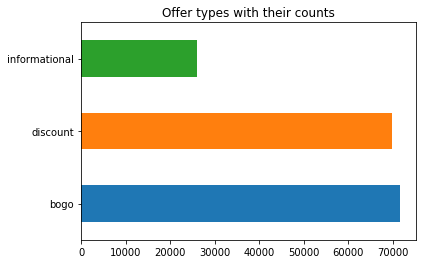

In [45]:
final_df['offer_type'].value_counts().plot.barh(title = 'Offer types with their counts')

So,we can see that discount and bogo are thr most given offer types

### Now we will see the different events and their counts

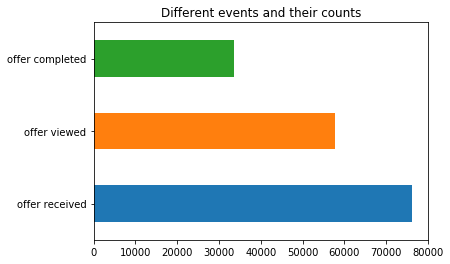

In [46]:
final_df['event'].value_counts().plot.barh(title = 'Different events and their counts')

So,in most of the cases offer is received by the user and it is not completed by him/her,means most of the people just ignore the offers they receive

### Now we will analyse this data on the basis of the age of the customers 

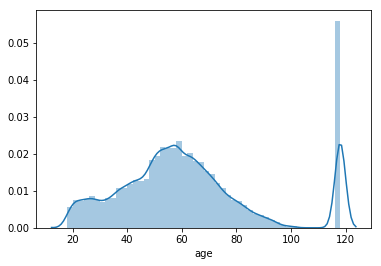

In [47]:
sns.distplot(final_df['age'] , bins = 50 , hist_kws = {'alpha' : 0.4});

As we can see that the people after the age of 100 are just acting as outliers,so we will remove them

In [48]:
final_df = final_df[final_df['age']<=100] 

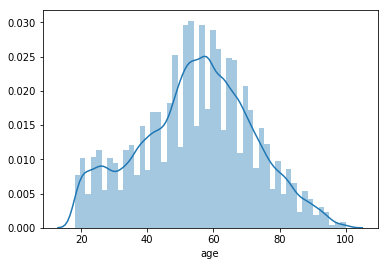

In [49]:
# Now seeing the distortion plot of age
sns.distplot(final_df['age'] , bins = 50 , hist_kws = {'alpha' : 0.4});

We can observe that most of the customers are within the age group of 45-60 are the most frequent customers and more than any other group,this is quite interesting.

### Now,we will analyse this data on the basis of income of the customers 

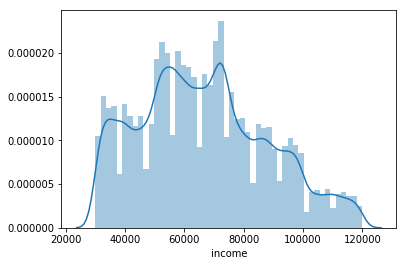

In [50]:
sns.distplot(final_df['income'] , bins = 50 , hist_kws = {'alpha' : 0.4});

In [51]:
final_df['income'].mean()

66413.346867983375

Now we can see that most people who are the customers of Starbucks have their income within the range of 55k - 75k with a mean income of 66413.35

### Now,we will see how our final dataframe is depedent on the 'gender' feature

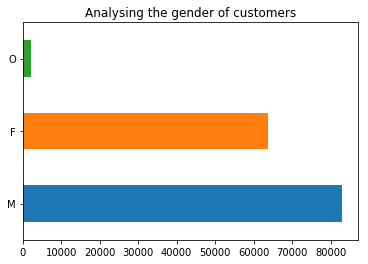

In [52]:
final_df['gender'].value_counts().plot.barh(title = 'Analysing the gender of customers')

So,we can see that most of the customers are male

### We will analyse the dataframe on the basis of  'offer_type' on the basis of gender

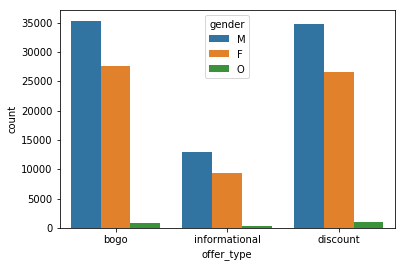

In [53]:
sns.countplot(x = 'offer_type' , hue = 'gender' , data = final_df)

We can see that the count of gender weather it is male or female is approximately equal in the bogo and discount offers

### Now,we will see the relation between gender and events 

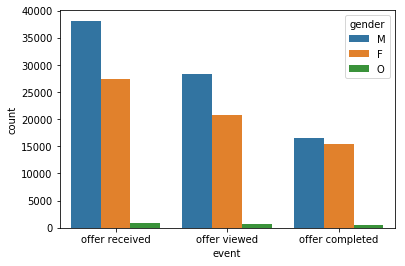

In [54]:
sns.countplot(x = 'event' , hue = 'gender' , data = final_df)

So,from the exploratory data analysis we can see that most of the customers just receive the offers and they do not view them and the people who complete the offers they receive is quite less and most of the offers made by Starbuks are BOGO and Discount and most of the people that are the customers are within the age group of 45-60 and the most common gender is male and the people who are the customers of Starbucks have their income within the range of 55k - 75k

# Making a Machine Learning Model

First analysing our final dataset

In [55]:
final_df

,channels,difficulty,duration,offer_id,offer_type,reward,event,customer_id,time,offer_reward,amount,age,became_member_on,gender,income
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,64,20170909,M,100000.0
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,64,20170909,M,100000.0
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,64,20170909,M,100000.0
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,64,20170909,M,100000.0
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,64,20170909,M,100000.0
5,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,offer received,4b0da7e80e5945209a1fdddfe813dbe0,408,0.0,0.0,64,20170909,M,100000.0
6,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,468,0.0,0.0,64,20170909,M,100000.0
7,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,offer received,4b0da7e80e5945209a1fdddfe813dbe0,168,0.0,0.0,64,20170909,M,100000.0
8,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,174,0.0,0.0,64,20170909,M,100000.0
9,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,180,5.0,0.0,64,20170909,M,100000.0


#### We will  now encode the categorical features like 'offer_type' , 'gender' , 'age'
#### We  will encode the offer_id and customer_id

In [58]:
final_df = pd.get_dummies(final_df , columns = ['offer_type' , 'gender' , 'age'])
#processing offer_id 
offer_id = final_df['offer_id'].unique().tolist()
offer_map = dict( zip(offer_id,range(len(offer_id))) )
final_df.replace({'offer_id': offer_map},inplace=True)

#processing customer_id 
customer_id = final_df['customer_id'].unique().tolist()
customer_map = dict( zip(customer_id,range(len(customer_id))) )
final_df.replace({'customer_id': customer_map},inplace=True)

In [59]:
final_df.head()

,channels,difficulty,duration,offer_id,reward,event,customer_id,time,offer_reward,amount,...,age_91,age_92,age_93,age_94,age_95,age_96,age_97,age_98,age_99,age_100
0,"[email, mobile, social]",10,7,0,10,offer received,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,"[email, mobile, social]",10,7,0,10,offer viewed,0,102,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,"[email, mobile, social]",10,7,0,10,offer received,0,504,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,"[email, mobile, social]",10,7,0,10,offer viewed,0,510,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,"[email, mobile, social]",10,7,0,10,offer completed,0,510,10.0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### Now we will scale the numerical data including 'income' , 'difficulty' , 'duration' and many more... 

In [60]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical_columns = ['income' , 'difficulty' , 'duration' , 'offer_reward' , 'time' , 'reward' , 'amount']
final_df[numerical_columns] = scaler.fit_transform(final_df[numerical_columns])

In [61]:
final_df.head()

,channels,difficulty,duration,offer_id,reward,event,customer_id,time,offer_reward,amount,...,age_91,age_92,age_93,age_94,age_95,age_96,age_97,age_98,age_99,age_100
0,"[email, mobile, social]",0.5,0.571429,0,1.0,offer received,0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,"[email, mobile, social]",0.5,0.571429,0,1.0,offer viewed,0,0.142857,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,"[email, mobile, social]",0.5,0.571429,0,1.0,offer received,0,0.705882,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,"[email, mobile, social]",0.5,0.571429,0,1.0,offer viewed,0,0.714286,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,"[email, mobile, social]",0.5,0.571429,0,1.0,offer completed,0,0.714286,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### We will encode the values in the 'event' column 

In [62]:
final_df['event'] = final_df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
final_df2 = final_df.drop('event' , axis = 1)

#### Now encoding the  channels column

In [63]:
final_df2['web'] = final_df2['channels'].apply(lambda x : 1 if 'web' in x else 0)
final_df2['mobile'] = final_df2['channels'].apply(lambda x : 1 if 'mobile' in x else 0)
final_df2['social'] = final_df2['channels'].apply(lambda x : 1 if 'social' in x else 0)
final_df2['email'] = final_df2['channels'].apply(lambda x : 1 if 'email' in x else 0)

In [64]:
#Now dropping the Channels column
final_df2.drop('channels' , axis = 1 , inplace = True)

In [65]:
final_df2['became_member_on'] = final_df2['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
#adding new columns for month & year
final_df2['month_member'] = final_df2['became_member_on'].apply(lambda x: x.day)
final_df2['year_member'] = final_df2['became_member_on'].apply(lambda x: x.year)
#dropping the  became_member_on column
final_df2.drop('became_member_on',axis=1, inplace=True)

In [66]:
final_df2.shape

(148754, 104)

# Training Our Dataset 

### Now splitting our 'final_df' into training and test set 

In [67]:
independent_variables = final_df2 #our dataset containing all the independent variables excluding the 'event'
dependent_variable = final_df['event'] #our final dataset containing the 'event'

In [68]:
from sklearn.model_selection import train_test_split
# splitting our dataset into training and test set and the test set being the 30% of the total dataset
x_train , x_test, y_train , y_test = train_test_split(independent_variables , dependent_variable , test_size = 0.3 , random_state = 1)

In [69]:
x_train.shape

(104127, 104)

In [70]:
x_test.shape

(44627, 104)

# Testing Our Dataset

In [71]:
# We will implement a number of classification machine learning methods and will determine which method is best for our model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [72]:
#We will test the quality of the predicted output on a number of metrics,i.e. accuracy score,f1 score
#We will use f1 score because it considers the class imbalance pretty well as compared to the accuracy score and is the best metric to evaluate our this model
from sklearn.metrics import confusion_matrix , accuracy_score , fbeta_score
def train_test_f1(model):
    """
    Returns the F1 score of training and test set of any particular model
    model : model name
    Returns
    f1_score_train : F1 score of training set
    f1_score_test : F1 score of test set
    """
    predict_train = (model.fit(x_train , y_train)).predict(x_train)
    predict_test = (model.fit(x_train , y_train)).predict(x_test)
    f1_score_train = fbeta_score(y_train , predict_train , beta = 0.5 , average = 'micro')*100
    f1_score_test = fbeta_score(y_test , predict_test , beta = 0.5 , average = 'micro')*100
    return f1_score_train , f1_score_test

### Implementing the KNN Model 

In [73]:
knn = KNeighborsClassifier()
f1_score_train_knn , f1_score_test_knn = train_test_f1(knn)#calculating the F1 scores

### Implementing the Logistic Regression

In [74]:
logistic = LogisticRegression()
f1_score_train_logistic , f1_score_test_logistic = train_test_f1(logistic)#calculating the F1 scores

### Implementing the Random Forest Classifier


In [75]:
random_forest = RandomForestClassifier()
f1_score_train_random , f1_score_test_random = train_test_f1(random_forest)#calculating the F1 scores

### Implementing the Decision Tree Classifier 

In [76]:
decision_tree = DecisionTreeClassifier()
f1_score_train_decision , f1_score_test_decision = train_test_f1(decision_tree)#calculating the F1 scores

# Concluding from the above models and scores

In [80]:
f1_scores_models = {'model_name' : [knn.__class__.__name__ , logistic.__class__.__name__ , random_forest.__class__.__name__ , decision_tree.__class__.__name__] 
                   , 'Training set F1 Score' : [f1_score_train_knn , f1_score_train_logistic , f1_score_train_random , f1_score_train_decision],
                   'Test set F1 Score' : [f1_score_test_knn , f1_score_test_logistic , f1_score_test_random , f1_score_test_decision]}
f1_scores_df = pd.DataFrame(f1_scores_models)

In [81]:
f1_scores_df

,model_name,Training set F1 Score,Test set F1 Score
0,KNeighborsClassifier,52.274626,30.564456
1,LogisticRegression,66.573511,66.571806
2,RandomForestClassifier,93.668309,64.803818
3,DecisionTreeClassifier,94.893736,86.003989


So,from the above dataframe we can conclude that when we trained our training dataset according to the KNeighborsClassifier our model performed worst,on training the model on RandomForestClassifier ,the training set F1 score is quite good i.e. 93.58 but it performed badly on the test set with a F1 score of 64.266 and when we trained our model on DecisionTreeClassifier our model's performance was best with the training set F1 score of 94.89 and the test set F1 score of 86.02,which means our model was able to classify between the events of offers upto a great extent.As this is a practical case study with real world dataset,we can say that our model has performed successfully.